## Preprocessing and conversion of data into sql database tables (SQLite database is used for simplicity)

Dataset downloaded from - https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus

The data was downloaded from above link and then extracted to movie-dialog-corpus directory

Below preprocessing steps add all of the related files as tables in an sqlite database

In [7]:
from sqlalchemy import create_engine, MetaData, Table, select
conn_string = (
    "sqlite:///../database/moviesdb.db"
    )

sqlite_engine = create_engine(conn_string, echo=True)

In [8]:
import traceback
import pandas as pd


In [9]:
# Manually fixed the line number 450, movie_id  m449
movie_title_df_columns = {
    0:'movie_id', 
    1:'movie_title',                           
    2:'year_of_release',  
    3:'IMDB_rating',
    4:'IMDB_number_of_votes',
    5:'movie_genre',
}

movie_titles_df = pd.read_csv('../movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None)
movie_titles_df.rename(columns= movie_title_df_columns, inplace=True)
movie_titles_df.head(2)

,movie_id,movie_title,year_of_release,IMDB_rating,IMDB_number_of_votes,movie_genre
0,m0,10 things i hate about you,1999,6.9,62847,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421,['adventure' 'biography' 'drama' 'history']


In [10]:
def convert_tab_to_space_df(x):
    try:
        return x.replace('\t', ' ')
    except:
        return x

In [11]:
movie_characters_df_columns = {
    0:'character_id', 
    1:'character_name',                           
    2:'movie_id',  
    3:'movie_title',
    4:'gender', # "?" for unlabeled cases
    5:'position_in_credits',
}

movie_characters_path = '../movie-dialog-corpus/movie_characters_metadata.tsv'
# movie_characters_df = pd.read_csv(movie_characters_path, sep='\t', header=None, error_bad_lines=False)
# movie_characters_df.rename(columns= movie_characters_df_columns, inplace=True)
# movie_characters_df.head(2)

line_list = []


with open(movie_characters_path, 'r', encoding='utf-8', newline='\n') as text:
    lines = text.read()
    ## Many characters were prsent which were causing lines to be skipped when reading directly from pandas, skipping those below
    replace_list = [u'\x85', u'\x85', u'\x82', u'\x8a', u'\x8c', u'\x91', 
                    u'\x92', u'\x93', u'\x94', u'\x96', u'\x97', u'\xad']
    
    for char in replace_list:
        lines = lines.replace(char, '')
    
    lines = lines.splitlines()
    for line in lines:
        line = line.lstrip('"').rstrip('"')
        line = line.split('\t', maxsplit=5)
        line_list.append(line)

movie_characters_df = pd.DataFrame(line_list, columns=movie_characters_df_columns.values())
movie_characters_df.head(2)

,character_id,character_name,movie_id,movie_title,gender,position_in_credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?


In [12]:
movie_lines_df_columns = {
    0:'movie_line_id', 
    1:'character_id', #(who uttered this phrase)                      
    2:'movie_id',  
    3:'character_name',
    4:'movie_line_text'
}
movie_lines_path = "../movie-dialog-corpus/movie_lines.tsv"
# movie_lines_df = pd.read_csv(movie_lines_path, sep='\t', header=None, encoding='utf-8-sig', error_bad_lines=False)
# movie_lines_df.rename(columns= movie_lines_df_columns, inplace=True)


# There were many lines getting skipped with above approach (commented lines) for movie_lines.tsv due to some additional characters in the file, hence used a different approach

line_list = []


with open(movie_lines_path, 'r', encoding='utf-8', newline='\n') as text:
    lines = text.read()
#     Many characters were prsent which were causing lines to be skipped when reading directly from pandas, skipping those below
    replace_list = [u'\x85', u'\x85', u'\x82', u'\x8a', u'\x8c', u'\x91', 
                    u'\x92', u'\x93', u'\x94', u'\x96', u'\x97', u'\xad']
    
    for char in replace_list:
        lines = lines.replace(char, '')
    
    lines = lines.splitlines()
    for line in lines:
        line = line.lstrip('"').rstrip('"')
        line = line.split('\t', maxsplit=4)
        line_list.append(line)

movie_lines_df = pd.DataFrame(line_list, columns=movie_lines_df_columns.values())
movie_lines_df['movie_line_text'] = movie_lines_df['movie_line_text'].map(convert_tab_to_space_df)

print(movie_lines_df.shape)
movie_lines_df.head(2)

(304713, 5)


,movie_line_id,character_id,movie_id,character_name,movie_line_text
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!


In [13]:
#  Fixed the lines with errors manually 
movie_conversations_df_columns = {
    0:'character_id_of_first_character',  # first character involved in the conversation
    1:'character_id_of_second_character',     
    2:'movie_id',  
    3:'list_of_line_id',
}

movie_conversations_df = pd.read_csv('../movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None)
movie_conversations_df.rename(columns= movie_conversations_df_columns, inplace=True)
print("Number of rows", movie_conversations_df.shape[0])
movie_conversations_df.head(2)

Number of rows 83097


,character_id_of_first_character,character_id_of_second_character,movie_id,list_of_line_id
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']


#### Splitting the column list_of_line_id in such a way that each row has single line id and other fields are repeated (used for maintaining atomicity


In [14]:
from itertools import chain
movie_conversations_df['list_of_line_id']= movie_conversations_df['list_of_line_id'].str.replace("]","").str.replace("[","")
df = movie_conversations_df
cols = df.columns.difference(['list_of_line_id'])
movie_line_id = df['list_of_line_id'].str.split(' ')

df =  (df.loc[df.index.repeat(movie_line_id.str.len()), cols]
         .assign(movie_line_id=list(chain.from_iterable(movie_line_id.tolist()))))
df['movie_line_id'] = df['movie_line_id'].str.replace("'","")
movie_conversations_df = df.reset_index(drop=True)
print("Number of rows", movie_conversations_df.shape[0])
movie_conversations_df.head(2)

C:\Users\hpune\AppData\Local\Temp\ipykernel_40948\3733146263.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_conversations_df['list_of_line_id']= movie_conversations_df['list_of_line_id'].str.replace("]","").str.replace("[","")


Number of rows 304713


,character_id_of_first_character,character_id_of_second_character,movie_id,movie_line_id
0,u0,u2,m0,L194
1,u0,u2,m0,L195


In [16]:
#  Fixed the lines with errors manually 
movie_script_urls_df_columns = {
    0:'movie_id',  # first character involved in the conversation
    1:'movie_title',     
    2:'movie_script_url'
}

movie_script_urls_df = pd.read_csv('../movie-dialog-corpus/raw_script_urls.tsv', sep='\t', header=None)
movie_script_urls_df.rename(columns= movie_script_urls_df_columns, inplace=True)
movie_script_urls_df.head(2)

,movie_id,movie_title,movie_script_url
0,m0,10 things i hate about you,http://www.dailyscript.com/scripts/10Things.html
1,m1,1492: conquest of paradise,http://www.hundland.org/scripts/1492-ConquestO...


## Creation of tables along with constraints on Primary key and foreign keys for SQLite Database

In [17]:
movie_titles_query = """
CREATE TABLE IF NOT EXISTS movie_titles (
    movie_id TEXT PRIMARY KEY, 
    movie_title TEXT, 
    year_of_release TEXT, 
    IMDB_rating FLOAT, 
    IMDB_number_of_votes BIGINT, 
    movie_genre TEXT
)
"""
sqlite_engine.execute(movie_titles_query)

try:
    movie_titles_df.to_sql(name='movie_titles', con=sqlite_engine, if_exists='append', index=False)  # replace can be used in if_exists but it will overwrite the schema and primary key info will be lost
except:
    # traceback.print_exc()
    print("Integrity error")

2023-04-16 02:31:22,644 INFO sqlalchemy.engine.Engine 
CREATE TABLE IF NOT EXISTS movie_titles (
    movie_id TEXT PRIMARY KEY, 
    movie_title TEXT, 
    year_of_release TEXT, 
    IMDB_rating FLOAT, 
    IMDB_number_of_votes BIGINT, 
    movie_genre TEXT
)

2023-04-16 02:31:22,644 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:22,650 INFO sqlalchemy.engine.Engine COMMIT
2023-04-16 02:31:22,655 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("movie_titles")
2023-04-16 02:31:22,656 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:22,658 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-16 02:31:22,663 INFO sqlalchemy.engine.Engine INSERT INTO movie_titles (movie_id, movie_title, year_of_release, "IMDB_rating", "IMDB_number_of_votes", movie_genre) VALUES (?, ?, ?, ?, ?, ?)
2023-04-16 02:31:22,664 INFO sqlalchemy.engine.Engine [generated in 0.00282s] (('m0', '10 things i hate about you', '1999', 6.9, 62847, "['comedy' 'romance']"), ('m1', '1492: conques

In [18]:
movie_characters_query = """CREATE TABLE  IF NOT EXISTS movie_characters (
    character_id TEXT PRIMARY KEY, 
    character_name TEXT, 
    movie_id TEXT, 
    movie_title TEXT, 
    gender TEXT, 
    position_in_credits TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id)
)"""
sqlite_engine.execute(movie_characters_query)
try:
    movie_characters_df['position_in_credits'] = movie_characters_df['position_in_credits'].fillna('?')
    movie_characters_df.to_sql(name='movie_characters', con=sqlite_engine, if_exists='append', index=False) # replace can be used in if_exists but it will overwrite the schema and primary key info will be lost
except: 
    # traceback.print_exc()
    print("Integrity error")

2023-04-16 02:31:24,928 INFO sqlalchemy.engine.Engine CREATE TABLE  IF NOT EXISTS movie_characters (
    character_id TEXT PRIMARY KEY, 
    character_name TEXT, 
    movie_id TEXT, 
    movie_title TEXT, 
    gender TEXT, 
    position_in_credits TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id)
)
2023-04-16 02:31:24,928 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:24,933 INFO sqlalchemy.engine.Engine COMMIT
2023-04-16 02:31:24,942 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("movie_characters")
2023-04-16 02:31:24,942 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:24,947 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-16 02:31:24,984 INFO sqlalchemy.engine.Engine INSERT INTO movie_characters (character_id, character_name, movie_id, movie_title, gender, position_in_credits) VALUES (?, ?, ?, ?, ?, ?)
2023-04-16 02:31:24,984 INFO sqlalchemy.engine.Engine [generated in 0.02782s] (('u0', 'BIANCA', 'm0', '10 things i hate about yo

In [19]:
movie_lines_query = """CREATE TABLE IF NOT EXISTS movie_lines (
    movie_line_id TEXT PRIMARY KEY, 
    character_id TEXT, 
    movie_id TEXT, 
    character_name TEXT, 
    movie_line_text TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id),
    FOREIGN KEY (character_id) REFERENCES movie_characters(character_id)
)
"""
sqlite_engine.execute(movie_lines_query)
try:
    movie_lines_df.to_sql(name='movie_lines', con=sqlite_engine, if_exists='append', index=False)
except: 
    # traceback.print_exc()
    print("Integrity error")

2023-04-16 02:31:25,760 INFO sqlalchemy.engine.Engine CREATE TABLE IF NOT EXISTS movie_lines (
    movie_line_id TEXT PRIMARY KEY, 
    character_id TEXT, 
    movie_id TEXT, 
    character_name TEXT, 
    movie_line_text TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id),
    FOREIGN KEY (character_id) REFERENCES movie_characters(character_id)
)

2023-04-16 02:31:25,761 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:25,765 INFO sqlalchemy.engine.Engine COMMIT
2023-04-16 02:31:25,827 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("movie_lines")
2023-04-16 02:31:25,828 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:25,956 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-16 02:31:27,223 INFO sqlalchemy.engine.Engine INSERT INTO movie_lines (movie_line_id, character_id, movie_id, character_name, movie_line_text) VALUES (?, ?, ?, ?, ?)
2023-04-16 02:31:27,224 INFO sqlalchemy.engine.Engine [generated in 1.09334s] (('L1045', 'u0', 'm0', '

In [20]:
movie_conversations_query = """
CREATE TABLE IF NOT EXISTS movie_conversations (
    character_id_of_first_character TEXT, 
    character_id_of_second_character TEXT, 
    movie_id TEXT, 
    movie_line_id TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id),
    FOREIGN KEY (character_id_of_first_character) REFERENCES movie_characters(character_id),
    FOREIGN KEY (character_id_of_second_character) REFERENCES movie_characters(character_id),
    FOREIGN KEY (movie_line_id) REFERENCES movie_lines(movie_line_id)    
)
"""
sqlite_engine.execute(movie_conversations_query)
try:
    movie_conversations_df.to_sql(name='movie_conversations', con=sqlite_engine, if_exists='append', index=False)
except: 
    traceback.print_exc()
    print("Integrity error")

2023-04-16 02:31:28,173 INFO sqlalchemy.engine.Engine 
CREATE TABLE IF NOT EXISTS movie_conversations (
    character_id_of_first_character TEXT, 
    character_id_of_second_character TEXT, 
    movie_id TEXT, 
    movie_line_id TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id),
    FOREIGN KEY (character_id_of_first_character) REFERENCES movie_characters(character_id),
    FOREIGN KEY (character_id_of_second_character) REFERENCES movie_characters(character_id),
    FOREIGN KEY (movie_line_id) REFERENCES movie_lines(movie_line_id)    
)

2023-04-16 02:31:28,174 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:28,179 INFO sqlalchemy.engine.Engine COMMIT
2023-04-16 02:31:28,197 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("movie_conversations")
2023-04-16 02:31:28,199 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:28,239 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-16 02:31:29,198 INFO sqlalchemy.engine.Engine INSERT INTO movie_c

In [21]:
movie_script_urls_query = """
CREATE TABLE IF NOT EXISTS movie_script_urls (
    movie_id TEXT PRIMARY KEY, 
    movie_title TEXT, 
    movie_script_url TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id)
)
"""
sqlite_engine.execute(movie_script_urls_query)
try:
    movie_script_urls_df.to_sql(name='movie_script_urls', con=sqlite_engine, if_exists='append', index=False)
except: 
    # traceback.print_exc()
    print("Integrity error")

2023-04-16 02:31:29,636 INFO sqlalchemy.engine.Engine 
CREATE TABLE IF NOT EXISTS movie_script_urls (
    movie_id TEXT PRIMARY KEY, 
    movie_title TEXT, 
    movie_script_url TEXT,
    FOREIGN KEY (movie_id) REFERENCES movie_titles(movie_id)
)

2023-04-16 02:31:29,637 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:29,641 INFO sqlalchemy.engine.Engine COMMIT
2023-04-16 02:31:29,645 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("movie_script_urls")
2023-04-16 02:31:29,645 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-04-16 02:31:29,648 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-04-16 02:31:29,651 INFO sqlalchemy.engine.Engine INSERT INTO movie_script_urls (movie_id, movie_title, movie_script_url) VALUES (?, ?, ?)
2023-04-16 02:31:29,652 INFO sqlalchemy.engine.Engine [generated in 0.00181s] (('m0', '10 things i hate about you', 'http://www.dailyscript.com/scripts/10Things.html'), ('m1', '1492: conquest of paradise', 'http://www.hundland.org/scripts/1492-C

### Finally, below is the ER Diagram of the created database is below

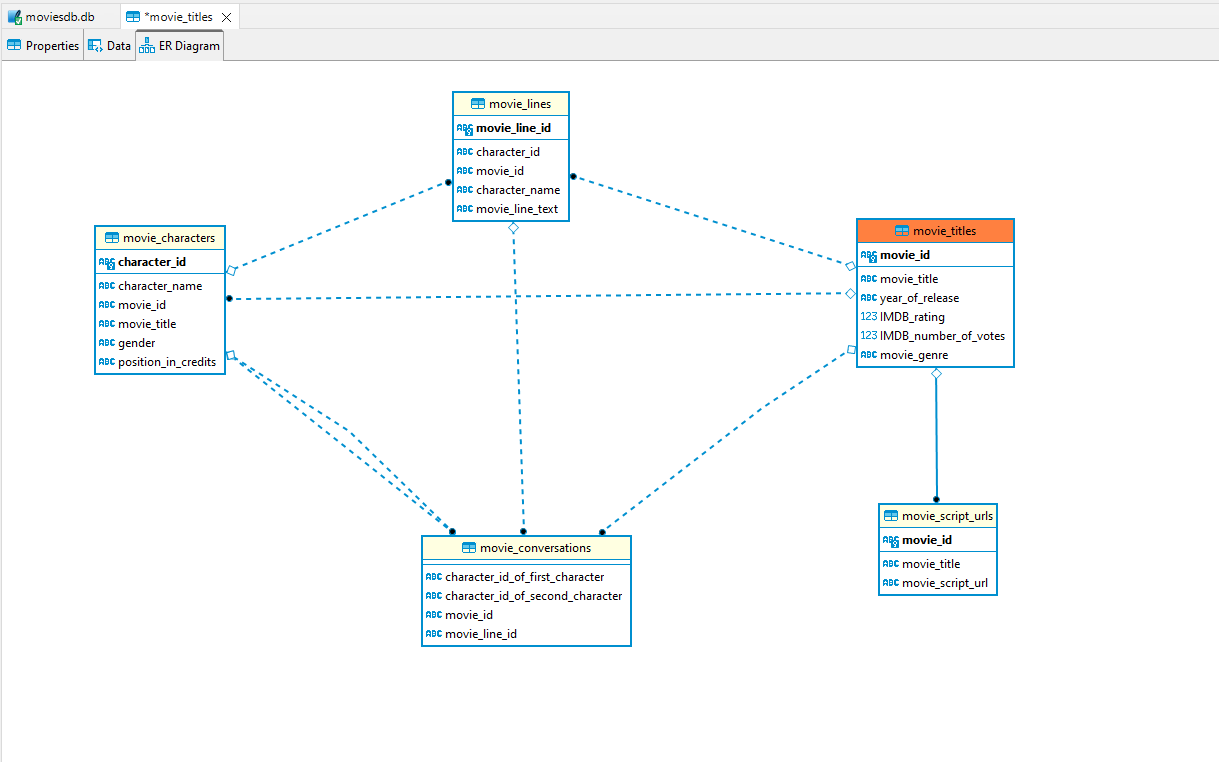